In [ ]:
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE = "/content/drive/MyDrive/DATASET(CSE425)"
META_FILE = "/content/drive/MyDrive/DATASET(CSE425)/processed/processed_metadata.csv"
LYRICS_DIR = f"{BASE}/lyrics"

In [65]:
meta = pd.read_csv(META_FILE)
print(meta.shape)

(3147, 11)


In [66]:
from tqdm import tqdm

lyrics_raw = []

for path in tqdm(meta["lyrics_path"], desc="Reading lyrics"):
    try:
        with open(path, "r", encoding="utf-8") as f:
            lyrics_raw.append(f.read())
    except:
        try:
            with open(path, "r", encoding="latin-1") as f:
                lyrics_raw.append(f.read())
        except:
            lyrics_raw.append("")


Reading lyrics: 100%|██████████| 3147/3147 [00:11<00:00, 269.89it/s]


In [67]:
meta["lyrics_raw"] = lyrics_raw

In [68]:
meta["empty"] = meta["lyrics_raw"].apply(lambda x: 1 if len(x.strip())==0 else 0)
meta["empty"].sum()


np.int64(0)

In [81]:
print(meta.shape)

(3147, 15)


In [73]:
!pip install langdetect --quiet

In [74]:
from langdetect import detect
import re

EN_STOP = set(["the","you","and","to","of","in","is","for","it","my","me","your","i","on","with","that","at","from","so","but","if","or"])

def english_score(text):
    words = re.findall(r"[A-Za-z]+", text.lower())
    if len(words)==0: return 0
    hits = sum(1 for w in words if w in EN_STOP)
    return hits / len(words)

def refine_english(text):
    s = english_score(text)
    try:
        model = detect(text)
    except:
        model = "unknown"

    if s < 0.02 and model != "en":
        return "OtherLatin"
    return "English"


In [75]:
mask = meta['RawLanguage'] == "English"
meta.loc[mask, 'RawLanguage'] = meta.loc[mask, "lyrics_raw"].apply(refine_english)

print(meta['RawLanguage'].value_counts())


RawLanguage
English    3046
Bangla       52
Korean       49
Name: count, dtype: int64


In [76]:
SUPPORTED = ["English","Bangla","Korean"]
meta = meta[meta["RawLanguage"].isin(SUPPORTED)].reset_index(drop=True)
print(meta["RawLanguage"].value_counts())


RawLanguage
English    3046
Bangla       52
Korean       49
Name: count, dtype: int64


In [77]:
import re

BANG = r"\u0980-\u09FF"
KOR  = r"\uAC00-\uD7A3"
LAT  = r"A-Za-z"

def clean_lyrics(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()


    text = re.sub(r"http\S+|www\S+", " ", text)


    text = re.sub(r"[\U00010000-\U0010ffff]", " ", text)


    allowed = f"[^{BANG}{KOR}{LAT}\\s]"
    text = re.sub(allowed, " ", text)

    text = re.sub(r"\s+", " ", text).strip()

    return text

meta["lyrics_clean"] = meta["lyrics_raw"].apply(clean_lyrics)


In [78]:
meta["word_count"] = meta["lyrics_clean"].apply(lambda s: len(s.split()))

In [80]:
meta.to_csv("/content/drive/MyDrive/DATASET(CSE425)/processed/processed_metadata.csv", index=False)


In [79]:
meta["word_count"].describe()

,word_count
count,3147.000000
mean,206.674611
std,177.086695
min,4.000000
25%,85.500000
50%,164.000000
75%,263.000000
max,1077.000000


In [ ]:
meta = meta[meta["word_count"] > 0].reset_index(drop=True)
print("Tracks after removing empty:", len(meta))
print(meta["RawLanguage"].value_counts())

Tracks after removing empty: 3147
RawLanguage
English    3046
Bangla       52
Korean       49
Name: count, dtype: int64


In [82]:
print(meta.columns.tolist())

['TrackID', 'Lyric_ID', 'RawGenre', 'RawLanguage', 'LyricsExists', 'sample_rate', 'Duration', 'Duration_sec', 'PrimaryGenre', 'audio_path', 'lyrics_path', 'lyrics_raw', 'empty', 'lyrics_clean', 'word_count']


In [ ]:
meta.to_csv("/content/drive/MyDrive/DATASET(CSE425)/processed/processed_metadata.csv", index=False)


In [84]:
meta["LyricsExists"] = meta["word_count"] > 0

In [ ]:
cols = [
    "TrackID","LyricID",
    "DurationSec","DurationRaw",
    "PrimaryGenre","RawGenre","AllGenres",
    "Language","RawLanguage",
    "LyricsExists","WordCount",
    "AudioPath","LyricsPath",
    "LyricsRaw","LyricsClean",
    "SampleRate"
]

meta = meta[[c for c in cols if c in meta.columns]]


In [85]:
!pip install sentence-transformers --quiet

In [86]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/LaBSE')

In [87]:
import numpy as np
from tqdm import tqdm

EMB_DIR = "/content/drive/MyDrive/DATASET(CSE425)/embeddings_labsE"
os.makedirs(EMB_DIR, exist_ok=True)

texts = meta['lyrics_clean'].tolist()
ids   = meta['TrackID'].tolist()

CHUNK = 500
n = len(texts)

for i in range(0, n, CHUNK):
    chunk_ids  = ids[i:i+CHUNK]
    chunk_text = texts[i:i+CHUNK]

    out_path = f"{EMB_DIR}/emb_chunk_{i//CHUNK:03d}.npz"
    if os.path.exists(out_path):
        print("Skipping existing:", out_path)
        continue

    emb = model.encode(chunk_text, batch_size=16, show_progress_bar=True)
    np.savez_compressed(out_path, ids=chunk_ids, emb=emb.astype(np.float32))

    print("Saved:", out_path)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DATASET(CSE425)/embeddings_labsE/emb_chunk_000.npz


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DATASET(CSE425)/embeddings_labsE/emb_chunk_001.npz


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DATASET(CSE425)/embeddings_labsE/emb_chunk_002.npz


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DATASET(CSE425)/embeddings_labsE/emb_chunk_003.npz


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DATASET(CSE425)/embeddings_labsE/emb_chunk_004.npz


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DATASET(CSE425)/embeddings_labsE/emb_chunk_005.npz


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/DATASET(CSE425)/embeddings_labsE/emb_chunk_006.npz


In [88]:
emb_chunks = sorted(os.listdir(EMB_DIR))
print("Total:", len(emb_chunks))


Total: 7


In [89]:
total = 0
for f in emb_chunks:
    d = np.load(os.path.join(EMB_DIR, f))
    total += len(d['ids'])
print("Total embedded:", total)


Total embedded: 3147


In [91]:
(
    meta.groupby('RawLanguage')
        .agg({
            'word_count':['mean','median','min','max','std','sum','count']
        })
        .round(2)
)

word_count                                       
                  mean median min   max     std     sum count
RawLanguage                                                  
Bangla          111.46   99.0  19   297   64.11    5796    52
English         210.70  169.0   4  1077  178.30  641796  3046
Korean           57.41   53.0  20   106   24.05    2813    49

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_eng = meta[meta['RawLanguage']=='English']

tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X = tfidf.fit_transform(df_eng['lyrics_clean'])

top_words = pd.Series(tfidf.get_feature_names_out())
top_words.head(30)


,0
0,abominable
1,ace
2,act
3,actin
4,action
5,admit
6,adore
7,affair
8,afford
9,afraid


In [96]:
def top_tfidf_words(df, genre, n=20):
    sub = df[df['PrimaryGenre']==genre]
    X = tfidf.fit_transform(sub['lyrics_clean'])
    idx = X.mean(0).A1.argsort()[::-1][:n]
    return tfidf.get_feature_names_out()[idx]

top_tfidf_words(df_eng,'Pop')


array(['yeah', 'baby', 'oh', 'love', 'know', 'don', 'll', 'just', 'want',
       'let', 'come', 'like', 'feel', 'got', 'time', 'heart', 'cause',
       'say', 'try', 'make'], dtype=object)

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


df = meta[meta['RawLanguage']=='English'].copy()

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    min_df=5
)

X = tfidf.fit_transform(df['lyrics_clean'])

print("TF-IDF shape:", X.shape)



TF-IDF shape: (3046, 4207)


In [117]:
pd.crosstab(meta['RawLanguage'], meta['PrimaryGenre'])

PrimaryGenre,AOR and Hard Rock,Acoustic,Acoustic Folk-Pop or Intimate Acoustic Alt Rock,Acoustic jazz,Adult Alternative Pop/Rock,Adult Contemporary,Album Rock,Alternative,Alternative Metal,Alternative Pop/Rock,...,Traditional Delta Blues,Traditional Pop,Unknown,Uptown Soul,Urban R&B/Pop,Vocal,Vocal Jazz,Vocal Pop,West Coast Rap,experimental pop
RawLanguage,,,,,,,,,,,,,,,,,,,,,
Bangla,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
English,1,2,1,1,3,5,4,0,1,1,...,6,2,34,1,1,20,1,1,1,2
Korean,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **VISUALIZATION**

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
top_genres = meta['PrimaryGenre'].value_counts()
keep = top_genres[top_genres >= 20].index

meta['GenreFiltered'] = meta['PrimaryGenre'].apply(lambda x: x if x in keep else 'Other')

/tmp/ipython-input-3621943850.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


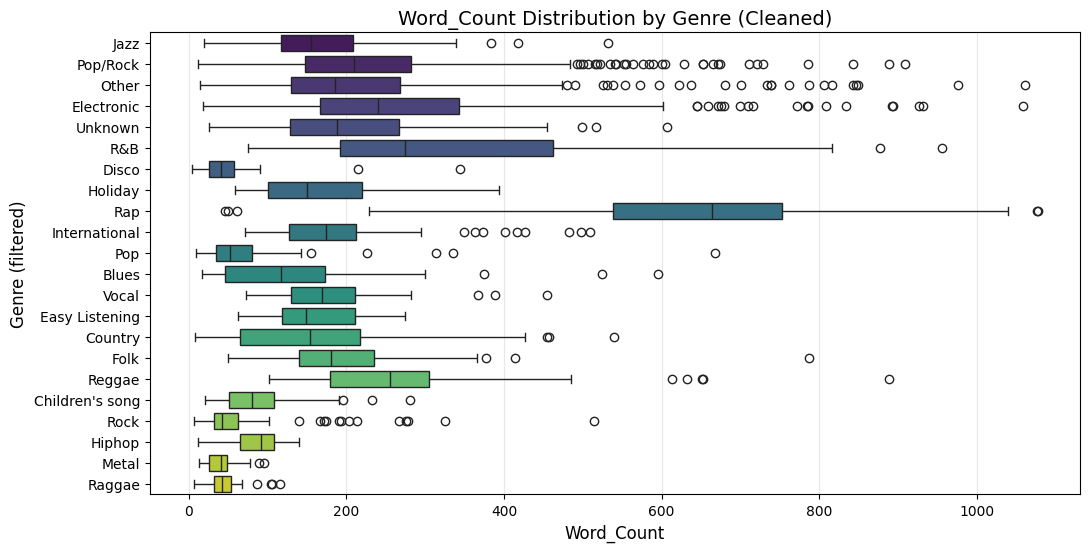

In [116]:
plt.figure(figsize=(12,6))
sns.boxplot(
    data=meta,
    x='word_count',
    y='GenreFiltered',
    palette='viridis'
)

plt.title("Word_Count Distribution by Genre (Cleaned)", fontsize=14)
plt.xlabel("Word_Count", fontsize=12)
plt.ylabel("Genre (filtered)", fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show()

In [108]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [109]:
from nltk.sentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

meta['sentiment'] = meta['lyrics_clean'].apply(lambda x: sid.polarity_scores(x)['compound'])


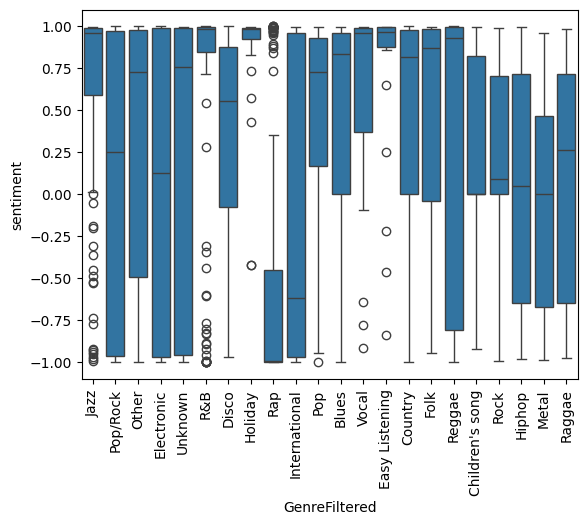

In [113]:
sns.boxplot(data=meta, x='GenreFiltered', y='sentiment')
plt.xticks(rotation=90)
plt.show()


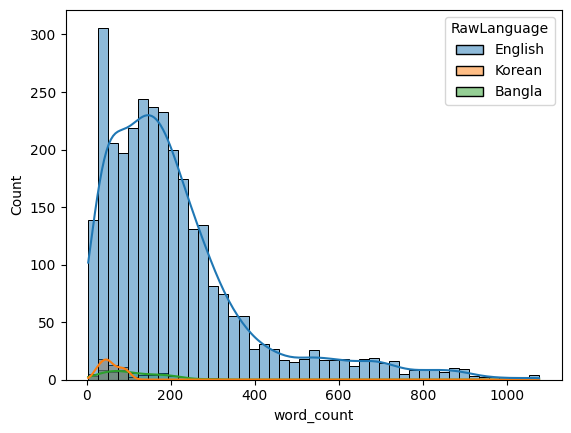

In [101]:
sns.histplot(data=meta, x='word_count', hue='RawLanguage', kde=True)
plt.show()

In [111]:
import numpy as np
import os

EMB_DIR = "/content/drive/MyDrive/DATASET(CSE425)/embeddings_labsE"

embeddings = []
ids = []

for fn in sorted(os.listdir(EMB_DIR)):
    if fn.endswith(".npz"):
        data = np.load(os.path.join(EMB_DIR, fn))
        embeddings.append(data['emb'])
        ids.extend(data['ids'])

lyrics_embeds = np.vstack(embeddings)
lyrics_ids = np.array(ids)

print("Embeddings shape:", lyrics_embeds.shape)
print("IDs:", len(lyrics_ids))


Embeddings shape: (3147, 768)
IDs: 3147


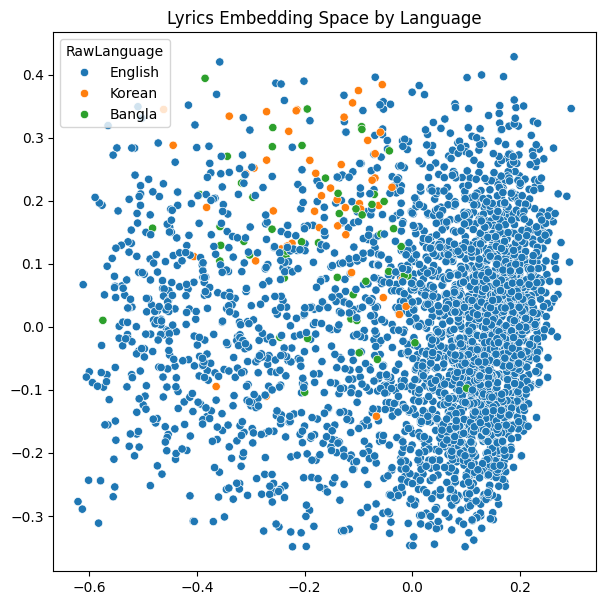

In [112]:
from sklearn.decomposition import PCA

X = lyrics_embeds
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.figure(figsize=(7,7))
sns.scatterplot(x=coords[:,0],y=coords[:,1], hue=meta['RawLanguage'])
plt.title("Lyrics Embedding Space by Language")
plt.show()


# **GENRE**

In [118]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
meta['genre_id'] = le.fit_transform(meta['PrimaryGenre'])


In [119]:
meta[['PrimaryGenre','genre_id']].head()

,PrimaryGenre,genre_id
0,Jazz,106
1,Pop/Rock,122
2,Soul,145
3,Outlaw Country,116
4,Dance-Rock,49


In [120]:
genre_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(genre_map)

{'AOR and Hard Rock': np.int64(0), 'Acoustic': np.int64(1), 'Acoustic Folk-Pop or Intimate Acoustic Alt Rock': np.int64(2), 'Acoustic jazz': np.int64(3), 'Adult Alternative Pop/Rock': np.int64(4), 'Adult Contemporary': np.int64(5), 'Album Rock': np.int64(6), 'Alternative': np.int64(7), 'Alternative Metal': np.int64(8), 'Alternative Pop/Rock': np.int64(9), 'Alternative Rock': np.int64(10), 'Alternative Rock / Indie Rock': np.int64(11), 'Alternative Rock / Indie Rock / Folk-Pop': np.int64(12), 'Alternative Rock Ballad': np.int64(13), 'Alternative Rock or Pop rock': np.int64(14), 'Alternative rock': np.int64(15), 'Alternative/Indie': np.int64(16), 'Alternative/Indie Pop/Shoegaze': np.int64(17), 'Alternative/Indie Rock': np.int64(18), 'Arena Rock': np.int64(19), 'Art Rock': np.int64(20), 'Art pop or Alternative': np.int64(21), 'Art rock or Synth-driven rock': np.int64(22), 'Avant-Garde': np.int64(23), 'Baroque Pop': np.int64(24), 'Blues': np.int64(25), 'Bollywood-style': np.int64(26), 'Bri

In [121]:
pd.Series(genre_map).to_csv("genre_map.csv")

In [123]:
meta.to_csv("/content/drive/MyDrive/DATASET(CSE425)/processed/processed_metadata.csv", index=False)
print("Saved updated metadata.")

Saved updated metadata.


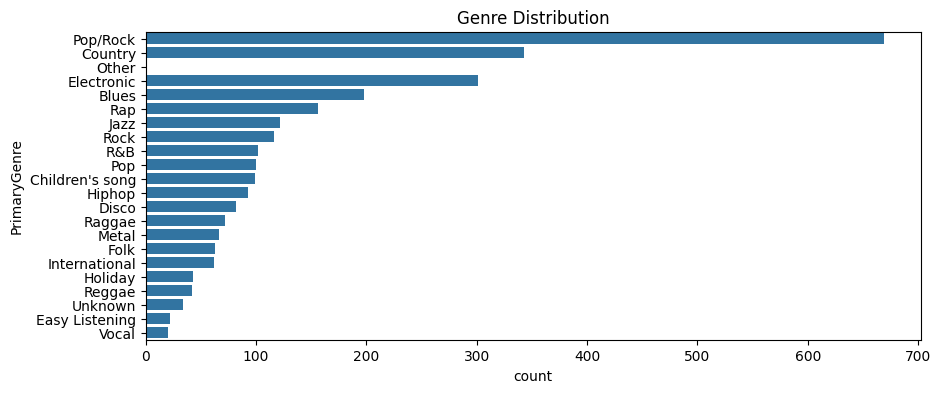

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.countplot(y=meta['PrimaryGenre'], order=meta['GenreFiltered'].value_counts().index)
plt.title("Genre Distribution")
plt.show()
